Part a) Modifying the program RLmlp,10 states are represented in the linear maze within a tabular representation of the states. The rewards at state 0  set at 1, and the rewards at state 9  set to two. The reward on all other states is 0. The discount factor  set to gamma=0.8. 

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from keras import models, layers, optimizers

def tau(s,a):
    if (s[0] and s[9]) == 0 : s=np.roll(s,a)
    return s

def rho(s):
    return ((s[0]==1)+2*(s[9]==1))    

def terminal_state(s):
    return (s[0]==1 or s[9]==1)    

gamma=0.8
invT = 1

In [23]:
# the network
inputs = layers.Input(shape=(10,))
h = layers.Dense(20, activation='relu')(inputs)
outputs = layers.Dense(2, activation='linear')(h)

model = models.Model(inputs=inputs, outputs=outputs)
RMSprop = optimizers.RMSprop(lr=0.01)
model.compile(loss='mse', optimizer=RMSprop)

In [24]:
for trial in range(400):
    s= np.array([0,0,0,0,1,0,0,0,0,0])
    for t in range(0,10):
        if terminal_state(s): break
        if trial > 30 and invT > 0.1: invT -= 0.001
        prediction=model.predict(s.reshape(1,10), steps=1, verbose=0)
        aidx=np.argmax(prediction)
        if np.random.rand() < invT : aidx=1-aidx
        a=2*aidx-1
        next_s = tau(s,a)
        if terminal_state(next_s): 
            y = rho(next_s)
        else:
            y = gamma*np.max(model.predict(next_s.reshape(1,10), steps=1, verbose=0))
        prediction[0,aidx]=y
        model.fit(s.reshape(1,10), prediction, epochs=1, verbose=0)
        s = np.copy(next_s)


Computed Q values and policies from trained model

In [25]:
policy = np.zeros(10)
Q=[]
s = np.array([1,0,0,0,0,0,0,0,0,0])

for i in range(0,10):
    Qs=model.predict(s.reshape(1,10), steps=1)
    Q.append(Qs)
    aidx=np.argmax(Qs)
    policy[i]=2*aidx-1
    s = np.roll(s,1)
print('Qvalues:', np.transpose(Q))
print('policy:',np.transpose(policy))

Qvalues: [[[0.5527975  0.85979396 0.6920488  0.6576191  0.46879047 0.6191393
   0.7462076  0.98538595 1.271344   0.58717245]]

 [[0.8877659  0.62498385 0.49571478 0.6049864  0.78184664 1.0031447
   1.2045466  1.5537133  1.9262716  0.63368785]]]
policy: [ 1. -1. -1. -1.  1.  1.  1.  1.  1.  1.]


Part b) Program where the state input is given with a simple number representing the state. 

In [26]:

def tau(s,a):
    if (s != 0 and s != 9) : s = s+a
    return s

def rho(s):
    return ((s == 0)+2*(s == 9))    

def terminal_state(s):
    return (s==0 or s==9)    

gamma=0.8
invT = 1

In [27]:
# the network
inputs = layers.Input(shape=(1,))
h = layers.Dense(10, activation='relu')(inputs)
outputs = layers.Dense(2, activation='linear')(h)

model = models.Model(inputs=inputs, outputs=outputs)
RMSprop = optimizers.RMSprop(lr=0.01)
model.compile(loss='mse', optimizer=RMSprop)

In [28]:
for trial in range(400):
    input = 4
    s= np.array([input])
    for t in range(0,10):
        if terminal_state(s): break
        if trial > 10 and invT > 0.1: invT -= 0.001
        prediction=model.predict(s.reshape(1,1), steps=1, verbose=0)
        aidx=np.argmax(prediction)
        if np.random.rand() < invT : aidx=1-aidx
        a=2*aidx-1
        next_s = tau(s,a)
        if terminal_state(next_s): 
            y = rho(next_s)
        else:
            y = gamma*np.max(model.predict(next_s.reshape(1,1), steps=1, verbose=0))
        prediction[0,aidx]=y
        model.fit(s.reshape(1,1), prediction, epochs=1, verbose=0)
        s = np.copy(next_s)


Computed Q values and policies from trained model

In [29]:
policy = np.zeros(10)
Q=[]
s = np.array([0])
for i in range(0,10):
    Qs=model.predict(s.reshape(1,1), steps=1)
    Q.append(Qs)
    aidx=np.argmax(Qs)
    policy[i]=2*aidx-1
    s = s+1
print('Q value:',np.transpose(Q))
print('policy:',np.transpose(policy))

Q value: [[[ 1.1015149   1.001903    0.8005586   0.638415    0.5216539
    0.4048928   0.2881317   0.17351794  0.06296086 -0.04759622]]

 [[ 0.8446406   0.61589694  0.40262255  0.30086264  0.3253796
    0.34989658  0.37441355  0.39706606  0.41619626  0.43532646]]]
policy: [-1. -1. -1. -1. -1. -1.  1.  1.  1.  1.]


Part c) Program where a trained network is used to recognise a hand-written number from MNIST that then becomes the input.

(60000, 28, 28)


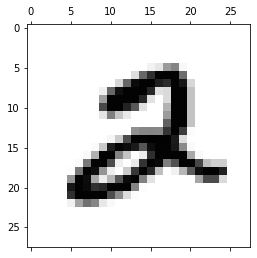

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from keras import models, layers, optimizers, datasets, utils, losses

(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()
print(np.shape(x_train))
plt.matshow(255-x_train[5,:,:], cmap='gray')

In [31]:
x_train = x_train.reshape(60000, 28, 28, 1)/255
x_train = x_train[:1024,:,:,:]
x_test = x_test.reshape(10000, 28, 28, 1)/255
y_train = utils.to_categorical(y_train[:1024], 10)
y_test = utils.to_categorical(y_test, 10)

inputs = layers.Input(shape=(28, 28, 1,))
x=layers.Conv2D(32, kernel_size=(3, 3),activation='relu')(inputs)
x=layers.Conv2D(64, (3, 3), activation='relu')(x)
x=layers.MaxPooling2D(pool_size=(2, 2))(x)
x=layers.Dropout(0.25)(x)
x=layers.Flatten()(x)
x=layers.Dense(128, activation='relu')(x)
x=layers.Dropout(0.5)(x)
outputs=layers.Dense(10, activation='softmax')(x)

model = models.Model(inputs=inputs, outputs=outputs)

model.compile(loss=losses.categorical_crossentropy,
              optimizer=optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=128,
          epochs=10,
          verbose=1,
          validation_data=(x_test, y_test))


Epoch 1/10
8/8 [==============================] - 7s 923ms/step - loss: 2.2991 - accuracy: 0.1426 - val_loss: 2.3001 - val_accuracy: 0.1214
Epoch 2/10
8/8 [==============================] - 7s 912ms/step - loss: 2.2991 - accuracy: 0.1152 - val_loss: 2.2995 - val_accuracy: 0.1221
Epoch 3/10
8/8 [==============================] - 7s 912ms/step - loss: 2.3002 - accuracy: 0.1426 - val_loss: 2.2989 - val_accuracy: 0.1229
Epoch 4/10
8/8 [==============================] - 7s 910ms/step - loss: 2.2987 - accuracy: 0.1299 - val_loss: 2.2984 - val_accuracy: 0.1238
Epoch 5/10
8/8 [==============================] - 7s 910ms/step - loss: 2.2985 - accuracy: 0.1338 - val_loss: 2.2978 - val_accuracy: 0.1249
Epoch 6/10
8/8 [==============================] - 7s 910ms/step - loss: 2.2965 - accuracy: 0.1426 - val_loss: 2.2972 - val_accuracy: 0.1260
Epoch 7/10
8/8 [==============================] - 7s 911ms/step - loss: 2.2920 - accuracy: 0.1357 - val_loss: 2.2966 - val_accuracy: 0.1271
Epoch 8/10
8/8 [====

In [32]:
y_pred = model.predict(x_test)

In [33]:
y_pred[1]


array([0.1010065 , 0.10406297, 0.10054718, 0.09768872, 0.09274782,
       0.09882107, 0.10310592, 0.09867769, 0.10133501, 0.10200706],
      dtype=float32)

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from keras import models, layers, optimizers

def tau(s,a):
    if (s[0] and s[9]) == 0 : s=np.roll(s,a)
    return s

def rho(s):
    return ((s[0]==1)+2*(s[9]==1))    

def terminal_state(s):
    return (s[0]==1 or s[9]==1)    

gamma=0.8
invT = 1

In [35]:
# the network
inputs = layers.Input(shape=(10,))
h = layers.Dense(20, activation='relu')(inputs)
outputs = layers.Dense(2, activation='linear')(h)

model = models.Model(inputs=inputs, outputs=outputs)
RMSprop = optimizers.RMSprop(lr=0.01)
model.compile(loss='mse', optimizer=RMSprop)

In [36]:
for trial in range(400):
    s= y_pred[1]
    for t in range(0,10):
        if terminal_state(s): break
        if trial > 30 and invT > 0.1: invT -= 0.001
        prediction=model.predict(s.reshape(1,10), steps=1, verbose=0)
        aidx=np.argmax(prediction)
        if np.random.rand() < invT : aidx=1-aidx
        a=2*aidx-1
        next_s = tau(s,a)
        if terminal_state(next_s): 
            y = rho(next_s)
        else:
            y = gamma*np.max(model.predict(next_s.reshape(1,10), steps=1, verbose=0))
        prediction[0,aidx]=y
        model.fit(s.reshape(1,10), prediction, epochs=1, verbose=0)
        s = np.copy(next_s)


Computed Q values and policies from trained model

In [37]:
policy = np.zeros(10)
Q=[]
s = np.array([1,0,0,0,0,0,0,0,0,0])

for i in range(0,10):
    Qs=model.predict(s.reshape(1,10), steps=1)
    Q.append(Qs)
    aidx=np.argmax(Qs)
    policy[i]=2*aidx-1
    s = np.roll(s,1)
print('Qvalues::',np.transpose(Q))
print('policy:',np.transpose(policy))

Qvalues:: [[[ 0.11960339 -0.03430711  0.17766713 -0.24672556  0.00318126
    0.07185458 -0.01885923 -0.11575116 -0.25628853  0.0263079 ]]

 [[ 0.32696596  0.01218712  0.2522636   0.22359307  0.2993686
    0.21260919  0.3414943   0.19178493  0.32430103  0.02827294]]]
policy: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
